In [1]:
import os
original_working_directory = os.getcwd()
print("The original working directory is {0}".format(os.getcwd()))

def reset_working_directory():
    os.chdir(original_working_directory)
    print("Reset working directory to original {0}".format(original_working_directory))

The original working directory is /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code/data/data_exploration


In [2]:
# Add the parent directory to the list of directories
# that the interpreter will search for dependencies 
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [1]:
import os

original_working_directory_path = os.getcwd()
print("The original working directory is {0}".format(os.getcwd()))

def to_original_working_directory():
    os.chdir(original_working_directory_path)
    print(f"Changed to original working directory {original_working_directory_path}")

The original working directory is /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code/data/data_exploration


In [2]:
def to_root_working_directory():
    root_working_directory_path = os.path.join(original_working_directory_path, "../..")
    os.chdir(root_working_directory_path)
    print(f"Changed to root working directory {os.getcwd()}")

In [3]:
to_root_working_directory()

Changed to root working directory /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code


# 1. Data Availability

In [4]:
import os
from tabulate import tabulate
from src.data_provider import DataProvider, time_status_columns, all_zero_columns, cols_to_exclude, decision_state, \
    afterstate
from src.custom_types import Behavior, MTDTechnique

In [16]:
def show_raw_behaviors_data_availability(raw=False, pi=3, decision=False):
    all_data = DataProvider.parse_no_mtd_behavior_data(filter_outliers=not raw,
                                                       filter_suspected_external_events=not raw,
                                                       pi=pi, decision=decision)
    all_data['attack'] = all_data['attack'].apply(lambda x: x.value)

    print(f'Total data points: {len(all_data)}')
    drop_cols = [col for col in list(all_data) if col not in ['attack', 'kmem:kmalloc']]
    grouped = all_data.drop(drop_cols, axis=1).rename(columns={'kmem:kmalloc': 'count'}).groupby(
        ['attack'], as_index=False).count()
    labels = ['Behavior', 'Count']
    rows = []
    for behavior in Behavior:
        row = [behavior.value]
        cnt_row = grouped.loc[(grouped['attack'] == behavior.value)]
        if len(cnt_row) == 0: continue
        row += [cnt_row['count'].iloc[0]]
        rows.append(row)
    print(tabulate(
        rows, headers=labels, tablefmt="latex"))


def show_decision_and_afterstate_data_availability(raw=False):
    all_data = DataProvider.parse_agent_data_files_to_df(filter_outliers=not raw,
                                                         filter_suspected_external_events=not raw)

    print(f'Total agent data points: {len(all_data)}')
    drop_cols = [col for col in list(all_data) if col not in ['attack', 'state', 'kmem:kmalloc']]
    grouped = all_data.drop(drop_cols, axis=1).rename(columns={'kmem:kmalloc': 'count'}).groupby(
        ['attack', 'state'], as_index=False).count()

    decision_grouped = grouped[grouped['state'] == decision_state]
    after_grouped = grouped[grouped['state'] != decision_state]

    labels = ['Behavior', 'State', 'Count']
    print("decision states data availability")
    rows = []
    for behavior in [b for b in Behavior]:
        line = decision_grouped.loc[(decision_grouped['attack'] == behavior.value), :]
        rows.append(line.values.tolist()[0])
    print(tabulate(
        rows, headers=labels, tablefmt="latex"))

    print("afterstates data availability")
    rows = []
    for behavior in [b for b in Behavior]:
        lines = after_grouped.loc[(after_grouped['attack'] == behavior.value), :]
        for line in lines.values.tolist():
            rows.append(line)
    print(tabulate(
        rows, headers=labels, tablefmt="latex"))


def print_column_info(raw_behaviors=True, pi=3):
    if raw_behaviors:
        df = DataProvider.parse_no_mtd_behavior_data(filter_suspected_external_events=False,
                                                     filter_constant_columns=False,
                                                     filter_outliers=False, keep_status_columns=True,
                                                     exclude_cols=False,
                                                     pi=pi, decision=False)
    else:
        df = DataProvider.parse_agent_data_files_to_df(filter_suspected_external_events=False,
                                                       filter_constant_columns=False,
                                                       filter_outliers=False, keep_status_columns=True,
                                                       exclude_cols=False)
        df = df.drop(['state'], axis=1)

    df = df.drop(['attack'], axis=1)
    constant_columns = df.loc[:, (df.nunique() <= 1)].columns  # df.columns[df.nunique() <= 1].values
    print("------------------Constant Columns-----------------------")
    print(constant_columns)
    print("---------------------CSV Columns-------------------------")
    labels = ['CSV Column', 'Event Source', 'Event', 'Constant', 'Status', 'Excluded', 'Feature']
    rows = []
    print("Please compare above columns to the marks in table below: "
          "They should be used for the agent data filtering")
    for col in df.columns:
        splitted = col.split(":")
        splind = (col.index(":") if ":" in col else 0) + 3
        splind = min(splind, len(col))
        row = [col if len(splitted) == 1 else (col[:splind] + "..")]
        row += [splitted[0] if (col not in time_status_columns and len(splitted) > 1) else ""]
        row += [(splitted[1] if len(splitted) > 1 else col) if col not in time_status_columns else ""]
        row += ["x" if col in all_zero_columns else ""]
        row += ["x" if col in time_status_columns else ""]
        row += ["x" if col in cols_to_exclude else ""]
        row += ["x" if (
                    col not in time_status_columns and col not in all_zero_columns and col not in cols_to_exclude) else ""]
        rows.append(row)
    print(tabulate(rows[:45], headers=labels, tablefmt='latex'))
    print(tabulate(rows[45:], headers=labels, tablefmt='latex'))

In [17]:
show_raw_behaviors_data_availability(raw=True, pi=3)

getting Behavior.NORMAL
getting Behavior.RANSOMWARE_POC
getting Behavior.ROOTKIT_BDVL
getting Behavior.ROOTKIT_BEURK
getting Behavior.CNC_THETICK
getting Behavior.CNC_BACKDOOR_JAKORITAR
getting Behavior.CNC_OPT1
getting Behavior.CNC_OPT2
Total data points: 59004
\begin{tabular}{lr}
\hline
 Behavior           &   Count \\
\hline
 normal             &   14702 \\
 bdvl               &    5698 \\
 beurk              &    7358 \\
 backdoor\_jakoritar &    4312 \\
 the\_tick           &    7704 \\
 data\_leak\_1        &    5687 \\
 data\_leak\_2        &    4162 \\
 ransomware\_poc     &    9381 \\
\hline
\end{tabular}


In [10]:
show_raw_behaviors_data_availability(raw=False, pi=3)

getting Behavior.NORMAL
getting Behavior.RANSOMWARE_POC
getting Behavior.ROOTKIT_BDVL
getting Behavior.ROOTKIT_BEURK
getting Behavior.CNC_THETICK
getting Behavior.CNC_BACKDOOR_JAKORITAR
getting Behavior.CNC_OPT1
getting Behavior.CNC_OPT2
Total data points: 39150
\begin{tabular}{lr}
\hline
 Behavior           &   Count \\
\hline
 normal             &   10340 \\
 bdvl               &    3247 \\
 beurk              &    4800 \\
 backdoor\_jakoritar &    2575 \\
 the\_tick           &    5123 \\
 data\_leak\_1        &    3778 \\
 data\_leak\_2        &    2664 \\
 ransomware\_poc     &    6623 \\
\hline
\end{tabular}


In [12]:
show_decision_and_afterstate_data_availability(raw=True)

Total agent data points: 77881
decision states data availability
\begin{tabular}{llr}
\hline
 Behavior           & State    &   Count \\
\hline
 normal             & decision &    4178 \\
 bdvl               & decision &    1658 \\
 beurk              & decision &    2012 \\
 backdoor\_jakoritar & decision &    2018 \\
 the\_tick           & decision &    1507 \\
 data\_leak\_1        & decision &    2080 \\
 data\_leak\_2        & decision &    2075 \\
 ransomware\_poc     & decision &    1804 \\
\hline
\end{tabular}
afterstates data availability
\begin{tabular}{llr}
\hline
 Behavior           & State                                &   Count \\
\hline
 normal             & after cnc\_ip\_shuffle                 &    2031 \\
 normal             & after ransomware\_directory\_trap      &    2084 \\
 normal             & after ransomware\_file\_extension\_hide &    1971 \\
 normal             & after rootkit\_sanitizer              &    1971 \\
 bdvl               & after cnc\_ip\_shuffl

In [13]:
show_decision_and_afterstate_data_availability(raw=False)

Total agent data points: 49252
decision states data availability
\begin{tabular}{llr}
\hline
 Behavior           & State    &   Count \\
\hline
 normal             & decision &    2468 \\
 bdvl               & decision &    1066 \\
 beurk              & decision &    1188 \\
 backdoor\_jakoritar & decision &    1242 \\
 the\_tick           & decision &     943 \\
 data\_leak\_1        & decision &    1359 \\
 data\_leak\_2        & decision &    1391 \\
 ransomware\_poc     & decision &    1147 \\
\hline
\end{tabular}
afterstates data availability
\begin{tabular}{llr}
\hline
 Behavior           & State                                &   Count \\
\hline
 normal             & after cnc\_ip\_shuffle                 &    1288 \\
 normal             & after ransomware\_directory\_trap      &    1334 \\
 normal             & after ransomware\_file\_extension\_hide &    1264 \\
 normal             & after rootkit\_sanitizer              &    1192 \\
 bdvl               & after cnc\_ip\_shuffl

# 2. Data Plotting

In [12]:
from typing import List, Tuple, Union

import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import numpy as np
from docutils.nodes import title

from custom_types import Behavior, RaspberryPi, MTDTechnique
from data_provider import DataProvider, decision_state

In [13]:
class DataPlotter:

    @staticmethod
    def plot_decision_or_afterstate_behaviors_timeline(decision_states: List[Tuple[Behavior, str]] = [],
                                                       afterstates: List[Tuple[Behavior, MTDTechnique, str]] = [],
                                                       plot_name: Union[str, None] = None):
        all_data = DataProvider.parse_agent_data_files_to_df(filter_outliers=False,
                                                             filter_suspected_external_events=False,
                                                             exclude_cols=False)
        # find max num samples
        max_number_of_samples = 0
        for behavior in decision_states:
            df_behavior = all_data.loc[(all_data['attack'] == behavior[0])]
            if len(df_behavior) > max_number_of_samples:
                max_number_of_samples = len(df_behavior)
        for behavior in afterstates:
            df_behavior = all_data.loc[(all_data['attack'] == behavior[0]) &
                                       (all_data['state'].str.contains(behavior[1]))]
            if len(df_behavior) > max_number_of_samples:
                max_number_of_samples = len(df_behavior)

        cols_to_plot = [col for col in all_data if col not in ['attack', 'state']]
        fig, axs = plt.subplots(nrows=ceil(len(cols_to_plot) / 4), ncols=4)
        axs = axs.ravel().tolist()
        fig.suptitle(plot_name)
        fig.set_figheight(len(cols_to_plot))
        fig.set_figwidth(50)

        all_decision = all_data[all_data['state'] == decision_state]
        all_after = all_data[all_data['state'] != decision_state]
        for i in range(len(cols_to_plot)):
            for behavior, line_color in decision_states:
                df_b = all_decision.loc[(all_decision['attack'] == behavior)]
                if (df_b[cols_to_plot[i]] < 0).any():
                    df_b = df_b[(df_b[cols_to_plot[i]] > 0)]
                xes_b = [i for i in range(max_number_of_samples)]
                ys_actual_b = df_b[cols_to_plot[i]].tolist()
                ys_upsampled_b = [ys_actual_b[i % len(ys_actual_b)] for i in range(max_number_of_samples)]
                axs[i].set_yscale('log')
                axs[i].plot(xes_b, ys_upsampled_b, color=line_color, label=(decision_state + " " + str(behavior)))
            for behavior, mtd, line_color in afterstates:
                df_b = all_after.loc[(all_after['attack'] == behavior) &
                                     (all_after['state'].str.contains(mtd))]
                if (df_b[cols_to_plot[i]] < 0).any():
                    df_b = df_b[(df_b[cols_to_plot[i]] > 0)]
                xes_b = [i for i in range(max_number_of_samples)]
                ys_actual_b = df_b[cols_to_plot[i]].tolist()
                ys_upsampled_b = [ys_actual_b[i % len(ys_actual_b)] for i in range(max_number_of_samples)]
                axs[i].plot(xes_b, ys_upsampled_b, color=line_color, label=(mtd + " " + str(behavior)))

            axs[i].set_title(cols_to_plot[i], fontsize='xx-large')
            axs[i].set_ylabel("log features")
            axs[i].set_xlabel("time steps")
            axs[i].legend(title='Behavior and MTD Results')

        fig.tight_layout()
        if plot_name is not None:
            fig.savefig(f'data_exploration/data_plot_{plot_name}.png', dpi=100)
            print(f'Saved {plot_name}')

    @staticmethod
    def plot_decision_or_afterstates_as_kde(decision_states: List[Tuple[Behavior, str]] = [],
                                            afterstates: List[Tuple[Behavior, MTDTechnique, str]] = [],
                                            raw_behaviors: List[Tuple[Behavior, str]] = [],
                                            plot_name: Union[str, None] = None):
        if len(raw_behaviors) > 0:
            raw_data = DataProvider.parse_no_mtd_behavior_data(filter_outliers=False,
                                                               filter_suspected_external_events=False, pi=3,
                                                               decision=False,exclude_cols=False)

        all_data = DataProvider.parse_agent_data_files_to_df(filter_outliers=True,
                                                             filter_suspected_external_events=False, exclude_cols=True)

        cols_to_plot = [col for col in all_data if col not in ['attack', 'state']]
        all_data = all_data.reset_index()
        all_decision = all_data[all_data['state'] == decision_state]
        all_after = all_data[all_data['state'] != decision_state]
        fig, axs = plt.subplots(nrows=ceil(len(cols_to_plot) / 4), ncols=4)
        axs = axs.ravel().tolist()
        fig.suptitle(plot_name)
        fig.set_figheight(len(cols_to_plot))
        fig.set_figwidth(50)
        for i in range(len(cols_to_plot)):
            axs[i].set_ylim([1e-6, 3 * 1e-1])  # adapt limitations specifically for features
            axs[i].set_xlabel("feature range")
            axs[i].set_ylabel("density")
            if len(raw_behaviors) > 0:
                for b, color in raw_behaviors:
                    series = raw_data[raw_data.attack == b][cols_to_plot[i]]
                    if series.unique().size == 1:
                        axs[i].axvline(series.iloc[0], ymin=1e-4, ymax=2, color=color)  # palette[f'{dv} {b}'])
                        continue
                    series = series[(np.isnan(series) == False) & (np.isinf(series) == False)]
                    sns.kdeplot(data=raw_data[raw_data.attack == b], x=cols_to_plot[i],
                                color=color, common_norm=True, common_grid=True, ax=axs[i], cut=2,
                                label=f"raw {b}", log_scale=(False, True))

            for b, color in decision_states:
                series = all_decision[all_decision.attack == b][cols_to_plot[i]]
                if series.unique().size == 1:
                    axs[i].axvline(series.iloc[0], ymin=1e-4, ymax=2, color=color)  # palette[f'{dv} {b}'])
                    continue
                series = series[(np.isnan(series) == False) & (np.isinf(series) == False)]
                sns.kdeplot(data=all_decision[all_decision.attack == b], x=cols_to_plot[i],
                            color=color, common_norm=True, common_grid=True, ax=axs[i], cut=2,
                            label=f"{decision_state} {b}", log_scale=(False, True))  # False, True
            for b, mtd, color in afterstates:
                series = all_after[(all_after['attack'] == b) & (all_after['state'].str.contains(mtd))][
                    cols_to_plot[i]]
                if series.unique().size == 1:
                    axs[i].axvline(series.iloc[0], ymin=1e-4, ymax=2, color=color)  # palette[f'{dv} {b}'])
                    continue
                series = series[(np.isnan(series) == False) & (np.isinf(series) == False)]
                sns.kdeplot(data=all_after[
                    (all_after['attack'] == b) & (all_after['state'].str.contains(mtd))],
                            x=cols_to_plot[i], color=color, common_norm=True, common_grid=True, ax=axs[i], cut=2,
                            label=f"{mtd} {b}", log_scale=(False, True))  # False, True

            axs[i].legend(title="State & Behavior/MTD")
            axs[i].set_title(cols_to_plot[i], fontsize='xx-large')
            # axs[i].set(xlabel=None)

        fig.tight_layout()
        if plot_name is not None:
            fig.savefig(f'data_exploration/data_plot_{plot_name}.png', dpi=100)

    @staticmethod
    def plot_normals_kde(plot_name, num_behaviors=4, colors=["green", "red", "blue", "violet"]):
        ndata = DataProvider.parse_normals(filter_outliers=True,
                                           filter_suspected_external_events=False)
        print(len(ndata))
        cols_to_plot = [col for col in ndata if col not in ['attack', 'state']]
        all_data = ndata.reset_index()
        fig, axs = plt.subplots(nrows=ceil(len(cols_to_plot) / 4), ncols=4)
        axs = axs.ravel().tolist()
        fig.suptitle(plot_name)
        fig.set_figheight(len(cols_to_plot))
        fig.set_figwidth(50)
        for i in range(len(cols_to_plot)):
            axs[i].set_ylim([1e-6, 0.5])  # adapt limitations specifically for features
            axs[i].set_xlabel("feature range")
            axs[i].set_ylabel("density")
            for j, color in zip(range(num_behaviors), colors):
                series = all_data[all_data['state'].str.contains(str(j))][cols_to_plot[i]]
                if series.unique().size == 1:
                    print("unique")
                    axs[i].axvline(series.iloc[0], ymin=1e-4, ymax=2, color=color)  # palette[f'{dv} {b}'])
                    continue
                series = series[(np.isnan(series) == False) & (np.isinf(series) == False)]
                sns.kdeplot(data=all_data[all_data['state'].str.contains(str(j))], x=cols_to_plot[i],
                            color=color, common_norm=True, common_grid=True, ax=axs[i], cut=2,
                            label=f"{str(j)} normal", log_scale=(False, True))  # False, True
            axs[i].legend(title="Normal Behaviors")
            axs[i].set_title(cols_to_plot[i], fontsize='xx-large')
            # axs[i].set(xlabel=None)

        fig.tight_layout()
        if plot_name is not None:
            fig.savefig(f'data_exploration/data_plot_{plot_name}.png', dpi=100)

    @staticmethod
    def plot_raw_behaviors_timeline(behaviors: List[Tuple[RaspberryPi, Behavior, str]], raw_behaviors: bool = True,
                                    plot_name: Union[str, None] = None, pi=3):

        all_data_parsed = DataProvider.parse_no_mtd_behavior_data(filter_outliers=False,
                                                                      filter_suspected_external_events=False, pi=pi, decision=False,
                                                                  exclude_cols=False)
        all_data_parsed['attack'] = all_data_parsed['attack'].apply(lambda x: x)
        # first find max number of samples
        max_number_of_samples = 0
        for behavior in behaviors:
            df_behavior = all_data_parsed.loc[
                (all_data_parsed['attack'] == behavior[1])]
            if len(df_behavior) > max_number_of_samples:
                max_number_of_samples = len(df_behavior)

        cols_to_plot = [col for col in all_data_parsed if col not in ['attack']]
        fig, axs = plt.subplots(nrows=ceil(len(cols_to_plot) / 4), ncols=4)
        axs = axs.ravel().tolist()
        fig.suptitle(plot_name)
        fig.set_figheight(len(cols_to_plot))
        fig.set_figwidth(50)
        for i in range(len(cols_to_plot)):
            for device, behavior, line_color in behaviors:
                df_b = all_data_parsed.loc[
                    (all_data_parsed['attack'] == behavior)]  # & (all_data_parsed['device'] == device)]
                if (df_b[cols_to_plot[i]] < 0).any():
                    df_b = df_b[(df_b[cols_to_plot[i]] > 0)]
                xes_b = [i for i in range(max_number_of_samples)]
                ys_actual_b = df_b[cols_to_plot[i]].tolist()
                ys_upsampled_b = [ys_actual_b[i % len(ys_actual_b)] for i in range(max_number_of_samples)]
                axs[i].set_yscale('log')
                label = "RP3" if device == RaspberryPi.PI3_1GB else "RP4"
                axs[i].plot(xes_b, ys_upsampled_b, color=line_color, label=(label + " " + str(behavior)))
            axs[i].set_title(cols_to_plot[i], fontsize='xx-large')
            axs[i].set_ylabel("event counts")
            axs[i].set_xlabel("time steps")
            axs[i].legend(title='Device & Behavior')

        fig.tight_layout()
        if plot_name is not None:
            fig.savefig(f'data_exploration/data_plot_{plot_name}.png', dpi=100)
            print(f'Saved {plot_name}')

    @staticmethod
    def plot_raw_behaviors_kde(device: RaspberryPi):
        pi = 4 if device == RaspberryPi.PI4_2GB_WC else 3
        plot_name = f"all_behaviors_{device}_kde"
        all_data_parsed = DataProvider.parse_no_mtd_behavior_data(filter_outliers=True, pi=pi, decision=False)
        all_data_parsed['attack'] = all_data_parsed['attack'].apply(lambda x: x)
        cols_to_plot = [col for col in all_data_parsed if col not in ['attack']]
        dv = "RP3" if device == RaspberryPi.PI3_1GB else "RP4"
        all_data_parsed['Device & Behavior'] = all_data_parsed.apply(lambda row: f'{dv} {row.attack}', axis=1)
        # all_data_parsed['Monitoring'] = all_data_parsed.apply(lambda row: f'{device} {row.attack}', axis=1)
        # all_data_parsed = all_data_parsed.drop(['device'], axis=1)
        all_data_parsed = all_data_parsed.reset_index()
        fig, axs = plt.subplots(nrows=ceil(len(cols_to_plot) / 4), ncols=4)
        axs = axs.ravel().tolist()
        fig.suptitle(plot_name)
        fig.set_figheight(len(cols_to_plot))
        fig.set_figwidth(50)
        palette = {f'{dv} {Behavior.NORMAL}': "green",
                   f'{dv} {Behavior.ROOTKIT_BDVL}': "black",
                   f'{dv} {Behavior.ROOTKIT_BEURK}': "darkblue",
                   f'{dv} {Behavior.RANSOMWARE_POC}': "orange",
                   f'{dv} {Behavior.CNC_THETICK}': "grey",
                   f'{dv} {Behavior.CNC_BACKDOOR_JAKORITAR}': "red"}
        for i in range(len(cols_to_plot)):
            axs[i].set_ylim([1e-6, 2 * 1e-1])  # adapt limitations specifically for features
            axs[i].set_xlabel("feature range")
            axs[i].set_ylabel("density")
            for b in Behavior:
                series = all_data_parsed[all_data_parsed.attack == b][cols_to_plot[i]]
                if series.unique().size == 1:
                    axs[i].axvline(series.iloc[0], ymin=1e-4, ymax=2, color=palette[f'{dv} {b}'])
                    continue
                series = series[(np.isnan(series) == False) & (np.isinf(series) == False)]
                sns.kdeplot(data=all_data_parsed[all_data_parsed.attack == b], x=cols_to_plot[i], palette=palette,
                            hue="Device & Behavior",
                            common_norm=True, common_grid=True, ax=axs[i], cut=2, label=f"{dv} {b}",
                            log_scale=(False, True))  # False, True
            axs[i].legend(title="Device & Behavior")
            axs[i].set_title(cols_to_plot[i], fontsize='xx-large')
            # axs[i].set(xlabel=None)

        fig.tight_layout()
        if plot_name is not None:
            fig.savefig(f'data_exploration/data_plot_{plot_name}.png', dpi=100)

    @staticmethod
    def print_pca_scree_plot(n=30):
        pca = DataProvider.fit_pca()
        per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
        acc_per_var = [per_var[i] + np.sum(per_var[:i]) for i in range(len(per_var))]

        labels = ['PC' + str(x) for x in range(1, len(per_var) + 1)]
        xx = range(1, len(per_var) + 1)
        plt.plot(xx, acc_per_var, 'ro', label="accumulated explained variance")
        plt.bar(x=xx, height=per_var, tick_label=labels)
        plt.ylabel('Percentage of Explained Variance')
        plt.xlabel('Principal Component')
        plt.xticks(fontsize=6)
        plt.title('Scree Plot')
        plt.legend()
        plt.savefig(f"data_exploration/screeplot_n_{n}.png")



# 3. Data Visualization

kde
CURRENT WORKING DIR /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code/RL-for-IT-Sec


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


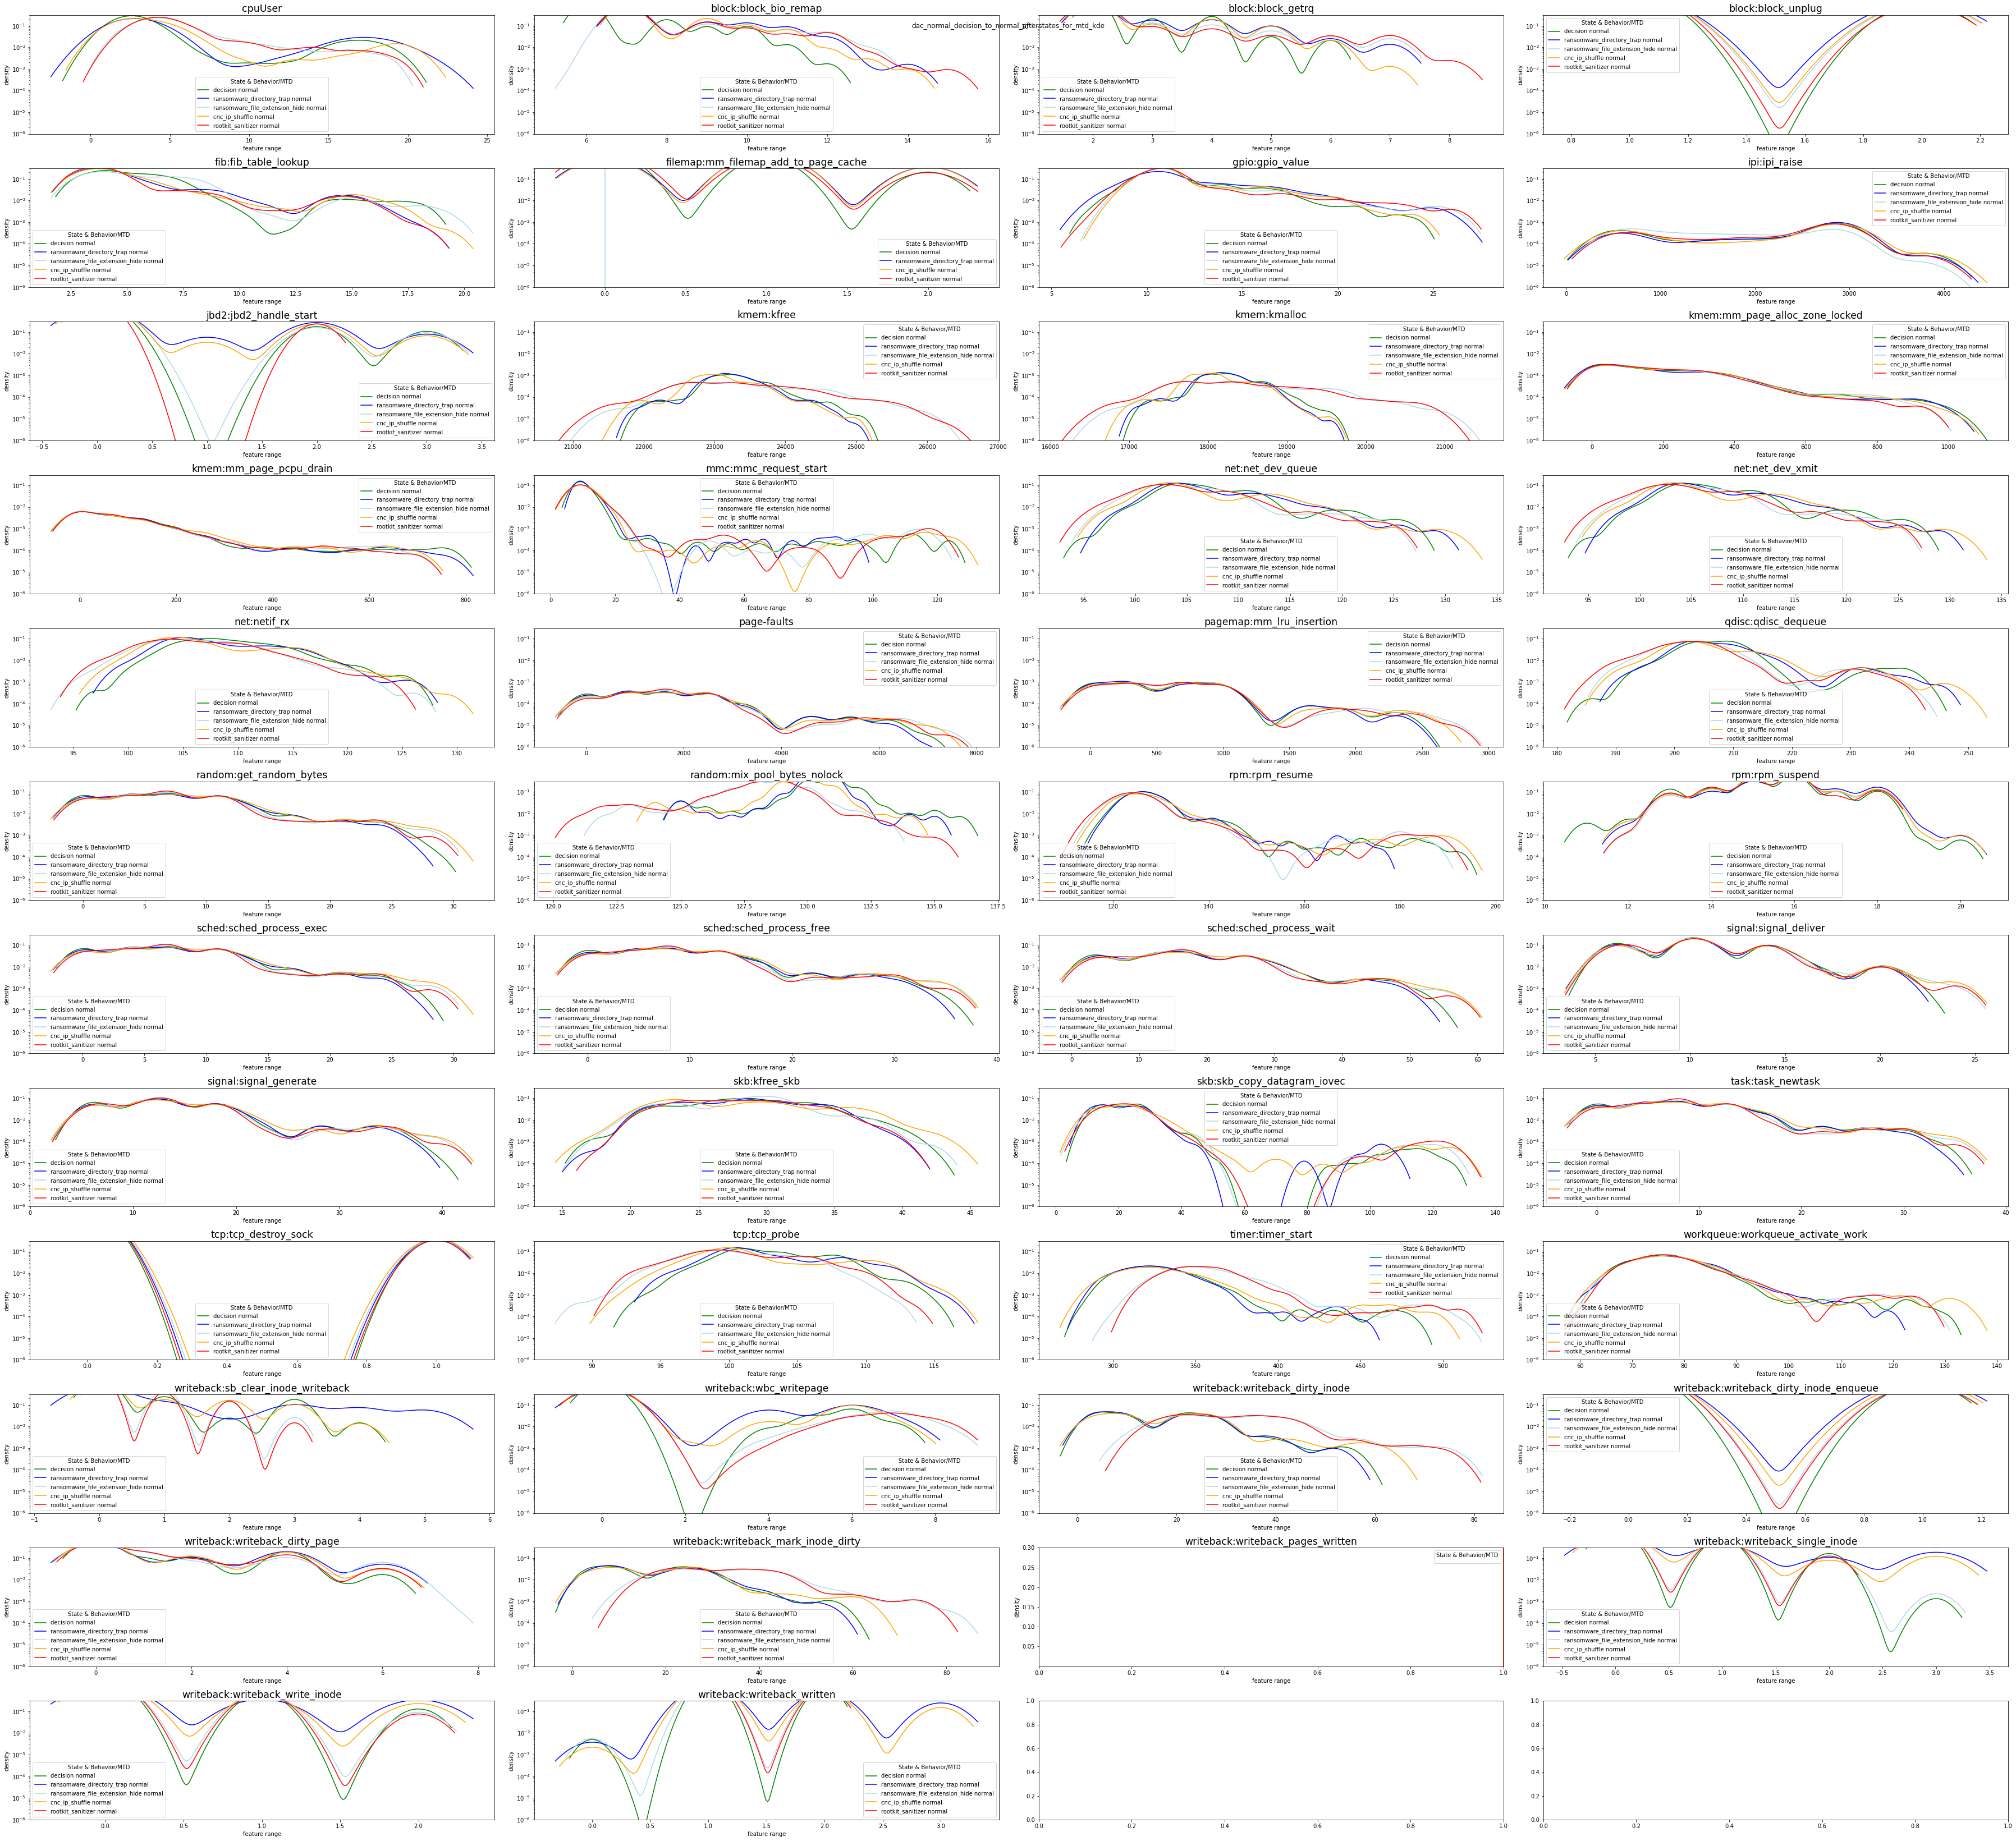

In [15]:
import os

from custom_types import Behavior, RaspberryPi, MTDTechnique
from data_plotting import DataPlotter

plot_kde = True
plot_timeline = False

if __name__ == "__main__":
    os.chdir(os.path.join(original_working_directory, "../"))
    if plot_kde:
        print("kde")

        # DataPlotter.plot_decision_or_afterstates_as_kde(raw_behaviors=[(Behavior.NORMAL, "green"),
        #                                                                (Behavior.ROOTKIT_BDVL, "blue"),
        #                                                                (Behavior.ROOTKIT_BEURK, "lightblue"),
        #                                                                (Behavior.RANSOMWARE_POC, "black"),
        #                                                                (Behavior.CNC_BACKDOOR_JAKORITAR, "violet"),
        #                                                                (Behavior.CNC_THETICK, "purple"),
        #                                                                (Behavior.CNC_OPT1, "orange"),
        #                                                                (Behavior.CNC_OPT2, "red")],
        #                                                 plot_name="all_raw_pi_3_1gb_kde")

        # DataPlotter.plot_decision_or_afterstates_as_kde(decision_states=
        #                                                      [(Behavior.NORMAL, "green"),
        #                                                       (Behavior.ROOTKIT_BDVL, "blue"),
        #                                                       (Behavior.ROOTKIT_BEURK, "lightblue"),
        #                                                       (Behavior.RANSOMWARE_POC, "black"),
        #                                                       (Behavior.CNC_BACKDOOR_JAKORITAR, "violet"),
        #                                                       (Behavior.CNC_THETICK, "purple"),
        #                                                       (Behavior.CNC_OPT1, "orange"),
        #                                                       (Behavior.CNC_OPT2, "red")],
        #                                                      plot_name="ds_comparison_pi_3_1gb_kde")


        # DataPlotter.plot_decision_or_afterstates_as_kde(
        #     decision_states=[(Behavior.ROOTKIT_BDVL, "blue"),
        #                      (Behavior.NORMAL, "green")],
        #     afterstates=[
        #         (Behavior.NORMAL, MTDTechnique.ROOTKIT_SANITIZER, "olive"),
        #         (Behavior.ROOTKIT_BDVL, MTDTechnique.ROOTKIT_SANITIZER, "lightgreen"),
        #         (Behavior.ROOTKIT_BDVL, MTDTechnique.RANSOMWARE_DIRTRAP, "lightblue"),
        #         (Behavior.ROOTKIT_BDVL, MTDTechnique.RANSOMWARE_FILE_EXT_HIDE, "purple"),
        #         (Behavior.ROOTKIT_BDVL, MTDTechnique.CNC_IP_SHUFFLE, "red"),
        #     ],
        #     plot_name="compare_bdvl_ds_as_kde")

        # DataPlotter.plot_decision_or_afterstates_as_kde(
        #     afterstates=[
        #         (Behavior.NORMAL, MTDTechnique.ROOTKIT_SANITIZER, "green"),
        #         (Behavior.RANSOMWARE_POC, MTDTechnique.ROOTKIT_SANITIZER, "black"),
        #         (Behavior.ROOTKIT_BDVL, MTDTechnique.ROOTKIT_SANITIZER, "blue"),
        #         (Behavior.ROOTKIT_BEURK, MTDTechnique.ROOTKIT_SANITIZER, "lightblue"),
        #         (Behavior.CNC_BACKDOOR_JAKORITAR, MTDTechnique.ROOTKIT_SANITIZER, "violet"),
        #         (Behavior.CNC_THETICK, MTDTechnique.ROOTKIT_SANITIZER, "purple"),
        #         (Behavior.CNC_OPT1, MTDTechnique.ROOTKIT_SANITIZER, "orange"),
        #         (Behavior.CNC_OPT2, MTDTechnique.ROOTKIT_SANITIZER, "red"),
        #     ],
        #     plot_name="compare_removerk_afterstates_kde")

        # DataPlotter.plot_decision_or_afterstates_as_kde(
        #     decision_states=[
        #         (Behavior.NORMAL, "green"),
        #         (Behavior.CNC_OPT1, "orange"),
        #     ],
        #     afterstates=[
        #         (Behavior.NORMAL, MTDTechnique.ROOTKIT_SANITIZER, "olive"),
        #         (Behavior.NORMAL, MTDTechnique.RANSOMWARE_DIRTRAP, "lightgreen"),
        #         (Behavior.NORMAL, MTDTechnique.RANSOMWARE_FILE_EXT_HIDE, "yellow"),
        #         (Behavior.NORMAL, MTDTechnique.CNC_IP_SHUFFLE, "darkgreen"),
        #         (Behavior.CNC_OPT1, MTDTechnique.ROOTKIT_SANITIZER, "black"),
        #         (Behavior.CNC_OPT1, MTDTechnique.RANSOMWARE_DIRTRAP, "blue"),
        #         (Behavior.CNC_OPT1, MTDTechnique.RANSOMWARE_FILE_EXT_HIDE, "lightblue"),
        #         (Behavior.CNC_OPT1, MTDTechnique.CNC_IP_SHUFFLE, "red"),
        #     ],
        #     plot_name="compare_cnc_opt_1")


        # DataPlotter.plot_normals_kde("compare_normals_kde")
        #
        #
        # DataPlotter.plot_decision_or_afterstates_as_kde(
        #     afterstates=[
        #         (Behavior.NORMAL, MTDTechnique.RANSOMWARE_DIRTRAP, "green"),
        #         (Behavior.RANSOMWARE_POC, MTDTechnique.RANSOMWARE_DIRTRAP, "blue"),
        #         (Behavior.ROOTKIT_BDVL, MTDTechnique.RANSOMWARE_DIRTRAP, "lightblue"),
        #         (Behavior.CNC_BACKDOOR_JAKORITAR, MTDTechnique.RANSOMWARE_DIRTRAP, "red"),
        #     ],
        #     plot_name="compare_dirtrap_afterstates_kde")
        #
        # DataPlotter.plot_decision_or_afterstates_as_kde(
        #     afterstates=[
        #         (Behavior.NORMAL, MTDTechnique.RANSOMWARE_FILE_EXT_HIDE, "green"),
        #         (Behavior.RANSOMWARE_POC, MTDTechnique.RANSOMWARE_FILE_EXT_HIDE, "blue"),
        #         (Behavior.ROOTKIT_BDVL, MTDTechnique.RANSOMWARE_FILE_EXT_HIDE, "lightblue"),
        #         (Behavior.CNC_BACKDOOR_JAKORITAR, MTDTechnique.RANSOMWARE_FILE_EXT_HIDE, "red"),
        #     ],
        #     plot_name="compare_fileextension_afterstates_kde")
        #
        # DataPlotter.plot_decision_or_afterstates_as_kde(
        #     afterstates=[
        #         (Behavior.NORMAL, MTDTechnique.CNC_IP_SHUFFLE, "green"),
        #         (Behavior.RANSOMWARE_POC, MTDTechnique.CNC_IP_SHUFFLE, "blue"),
        #         (Behavior.ROOTKIT_BDVL, MTDTechnique.CNC_IP_SHUFFLE, "lightblue"),
        #         (Behavior.CNC_BACKDOOR_JAKORITAR, MTDTechnique.CNC_IP_SHUFFLE, "red"),
        #     ],
        #     plot_name="compare_changeip_afterstates_kde")
        #


        print("CURRENT WORKING DIR {0}".format(os.getcwd()))
        #
        DataPlotter.plot_decision_or_afterstates_as_kde(
            [(Behavior.NORMAL, "green")],
            [(Behavior.NORMAL, MTDTechnique.RANSOMWARE_DIRTRAP, "blue"),
             (Behavior.NORMAL, MTDTechnique.RANSOMWARE_FILE_EXT_HIDE, "lightblue"),
             (Behavior.NORMAL, MTDTechnique.CNC_IP_SHUFFLE, "orange"),
             (Behavior.NORMAL, MTDTechnique.ROOTKIT_SANITIZER, "red")],
            plot_name="dac_normal_decision_to_normal_afterstates_for_mtd_kde")
        #
        # DataPlotter.plot_decision_or_afterstates_as_kde(
        #     [(Behavior.NORMAL, "green")],
        #     [(Behavior.RANSOMWARE_POC, MTDTechnique.RANSOMWARE_DIRTRAP, "blue"),
        #      (Behavior.RANSOMWARE_POC, MTDTechnique.RANSOMWARE_FILE_EXT_HIDE, "lightblue"),
        #      (Behavior.CNC_BACKDOOR_JAKORITAR, MTDTechnique.CNC_IP_SHUFFLE, "orange"),
        #      (Behavior.ROOTKIT_BDVL, MTDTechnique.ROOTKIT_SANITIZER, "red")],
        #     plot_name="dac_normal_behavior_to_correct_MTDs_afterstate_kde")
        #
        # DataPlotter.plot_decision_or_afterstates_as_kde(
        #     [(Behavior.RANSOMWARE_POC, "green")],
        #     [(Behavior.RANSOMWARE_POC, MTDTechnique.CNC_IP_SHUFFLE, "blue"),
        #      (Behavior.RANSOMWARE_POC, MTDTechnique.ROOTKIT_SANITIZER, "lightblue")],
        #     plot_name="dac_ransom_behavior_to_incorrect_MTDs_afterstate_kde")
        #
        # DataPlotter.plot_decision_or_afterstates_as_kde(
        #     [(Behavior.CNC_BACKDOOR_JAKORITAR, "green")],
        #     [(Behavior.CNC_BACKDOOR_JAKORITAR, MTDTechnique.RANSOMWARE_DIRTRAP, "blue"),
        #      (Behavior.CNC_BACKDOOR_JAKORITAR, MTDTechnique.RANSOMWARE_FILE_EXT_HIDE, "lightblue"),
        #      (Behavior.CNC_BACKDOOR_JAKORITAR, MTDTechnique.ROOTKIT_SANITIZER, "orange")],
        #     plot_name="dac_cnc_behavior_to_incorrect_MTDs_afterstate_kde")
        #
        # DataPlotter.plot_decision_or_afterstates_as_kde(
        #     [(Behavior.ROOTKIT_BDVL, "green")],
        #     [(Behavior.ROOTKIT_BDVL, MTDTechnique.RANSOMWARE_DIRTRAP, "blue"),
        #      (Behavior.ROOTKIT_BDVL, MTDTechnique.RANSOMWARE_FILE_EXT_HIDE, "lightblue"),
        #      (Behavior.ROOTKIT_BDVL, MTDTechnique.CNC_IP_SHUFFLE, "orange")],
        #     plot_name="dac_rootkit_behavior_to_incorrect_MTDs_afterstate_kde")
        #
        # DataPlotter.plot_decision_or_afterstates_as_kde(decision_states=[(Behavior.NORMAL, "green"),
        #                                                                  (Behavior.ROOTKIT_BDVL, "black"),
        #                                                                  (Behavior.ROOTKIT_BEURK, "darkviolet"),
        #                                                                  (Behavior.CNC_BACKDOOR_JAKORITAR, "blue"),
        #                                                                  (Behavior.RANSOMWARE_POC, "red"),
        #                                                                  (Behavior.CNC_OPT1, "orange"),
        #                                                                  (Behavior.CNC_THETICK, "grey")],
        #                                                 #raw_behaviors=[(Behavior.NORMAL, "pink")],
        #                                                 plot_name="ds_comparison_pi_3_1gb_kde")

        # DataPlotter.plot_decision_or_afterstates_as_kde(decision_states=[(Behavior.NORMAL, "green"),
        #                                                                  (Behavior.CNC_OPT1, "orange")],
        #                                                 afterstates=[
        #                                                     (Behavior.CNC_OPT1, MTDTechnique.RANSOMWARE_DIRTRAP, "red"),
        #                                                     (Behavior.CNC_OPT1, MTDTechnique.RANSOMWARE_FILE_EXT_HIDE,
        #                                                      "darkviolet"),
        #                                                     (
        #                                                     Behavior.CNC_OPT1, MTDTechnique.CNC_IP_SHUFFLE, "darkblue"),
        #                                                     (Behavior.CNC_OPT1, MTDTechnique.ROOTKIT_SANITIZER,
        #                                                      "lightblue")],
        #                                                 # raw_behaviors=[(Behavior.NORMAL, "pink")],
        #                                                 plot_name="cnc_opt_1_comparison")

        # DataPlotter.plot_decision_or_afterstates_as_kde(decision_states=[(Behavior.NORMAL, "green")],
        #                                            afterstates=[
        #                                                (Behavior.NORMAL, MTDTechnique.RANSOMWARE_DIRTRAP, "olive"),
        #                                                (Behavior.NORMAL, MTDTechnique.RANSOMWARE_FILE_EXT_HIDE, "lightgreen"),
        #                                                (Behavior.CNC_OPT2, MTDTechnique.RANSOMWARE_DIRTRAP, "red"),
        #                                                (Behavior.CNC_OPT2, MTDTechnique.RANSOMWARE_FILE_EXT_HIDE,
        #                                                 "darkviolet"),
        #                                                # (
        #                                                #     Behavior.CNC_OPT1, MTDTechnique.CNC_IP_SHUFFLE, "darkblue"),
        #                                                # (Behavior.CNC_OPT1, MTDTechnique.ROOTKIT_SANITIZER,
        #                                                #  "lightblue")
        #                                            ],
        #                                            # raw_behaviors=[(Behavior.NORMAL, "pink")],
        #                                            plot_name="cnc_opt_2_comparison")

        # DataPlotter.plot_decision_or_afterstates_as_kde(
        #     decision_states=[(Behavior.NORMAL, "darkgreen")],
        #     afterstates=[(Behavior.NORMAL, MTDTechnique.RANSOMWARE_DIRTRAP, "blue"),
        #                  (Behavior.NORMAL, MTDTechnique.RANSOMWARE_FILE_EXT_HIDE, "lightblue"),
        #                  (Behavior.NORMAL, MTDTechnique.CNC_IP_SHUFFLE, "orange"),
        #                  (Behavior.NORMAL, MTDTechnique.ROOTKIT_SANITIZER, "red")],
        #     #raw_behaviors=[(Behavior.NORMAL, "lightgreen")],
        #     plot_name="dac_normal_decision_and_afterstates_kde")

        # DataPlotter.plot_raw_behaviors_kde(RaspberryPi.PI4_2GB_WC)
        # DataPlotter.plot_raw_behaviors_kde(RaspberryPi.PI3_1GB)

        # UserWarning: Logscale warning can be ignored (some samples have negative values for feature iface0TX)
    if plot_timeline:
        print("timeline")
        # DataPlotter.plot_decision_or_afterstate_behaviors_timeline(
        #     afterstates=[
        #         (Behavior.NORMAL, MTDTechnique.RANSOMWARE_DIRTRAP, "green"),
        #         (Behavior.RANSOMWARE_POC, MTDTechnique.RANSOMWARE_DIRTRAP, "blue"),
        #          (Behavior.ROOTKIT_BDVL, MTDTechnique.RANSOMWARE_DIRTRAP, "lightblue"),
        #          (Behavior.CNC_BACKDOOR_JAKORITAR, MTDTechnique.RANSOMWARE_DIRTRAP, "red"),
        #          ],
        #         plot_name = "compare_dirtrap_afterstates_timeline")
        #
        # DataPlotter.plot_decision_or_afterstate_behaviors_timeline(
        #     afterstates=[
        #         (Behavior.NORMAL, MTDTechnique.RANSOMWARE_FILE_EXT_HIDE, "green"),
        #         (Behavior.RANSOMWARE_POC, MTDTechnique.RANSOMWARE_FILE_EXT_HIDE, "blue"),
        #         (Behavior.ROOTKIT_BDVL, MTDTechnique.RANSOMWARE_FILE_EXT_HIDE, "lightblue"),
        #         (Behavior.CNC_BACKDOOR_JAKORITAR, MTDTechnique.RANSOMWARE_FILE_EXT_HIDE, "red"),
        #     ],
        #     plot_name="compare_fileextension_afterstates_timeline")
        #
        # DataPlotter.plot_decision_or_afterstate_behaviors_timeline(
        #     afterstates=[
        #         (Behavior.NORMAL, MTDTechnique.CNC_IP_SHUFFLE, "green"),
        #         (Behavior.RANSOMWARE_POC, MTDTechnique.CNC_IP_SHUFFLE, "blue"),
        #         (Behavior.ROOTKIT_BDVL, MTDTechnique.CNC_IP_SHUFFLE, "lightblue"),
        #         (Behavior.CNC_BACKDOOR_JAKORITAR, MTDTechnique.CNC_IP_SHUFFLE, "red"),
        #     ],
        #     plot_name="compare_changeip_afterstates_timeline")
        #
        # DataPlotter.plot_decision_or_afterstate_behaviors_timeline(
        #     afterstates=[
        #         (Behavior.NORMAL, MTDTechnique.ROOTKIT_SANITIZER, "green"),
        #         (Behavior.RANSOMWARE_POC, MTDTechnique.ROOTKIT_SANITIZER, "blue"),
        #         (Behavior.ROOTKIT_BDVL, MTDTechnique.ROOTKIT_SANITIZER, "lightblue"),
        #         (Behavior.CNC_BACKDOOR_JAKORITAR, MTDTechnique.ROOTKIT_SANITIZER, "red"),
        #     ],
        #     plot_name="compare_removerk_afterstates_timeline")
        #
        #
        # DataPlotter.plot_decision_or_afterstate_behaviors_timeline(
        #     [(Behavior.NORMAL, "green")],
        #     [(Behavior.NORMAL, MTDTechnique.RANSOMWARE_DIRTRAP, "blue"),
        #      (Behavior.NORMAL, MTDTechnique.RANSOMWARE_FILE_EXT_HIDE, "lightblue"),
        #      (Behavior.NORMAL, MTDTechnique.CNC_IP_SHUFFLE, "orange"),
        #      (Behavior.NORMAL, MTDTechnique.ROOTKIT_SANITIZER, "red")],
        #     plot_name="dac_normal_decision_to_normal_afterstates_for_mtd_timeline")
        #
        # DataPlotter.plot_decision_or_afterstate_behaviors_timeline(
        #     [(Behavior.NORMAL, "green")],
        #     [(Behavior.RANSOMWARE_POC, MTDTechnique.RANSOMWARE_DIRTRAP, "blue"),
        #      (Behavior.RANSOMWARE_POC, MTDTechnique.RANSOMWARE_FILE_EXT_HIDE, "lightblue"),
        #      (Behavior.CNC_BACKDOOR_JAKORITAR, MTDTechnique.CNC_IP_SHUFFLE, "orange"),
        #      (Behavior.ROOTKIT_BDVL, MTDTechnique.ROOTKIT_SANITIZER, "red")],
        #     plot_name="dac_normal_behavior_to_correct_MTDs_afterstate_timeline")
        #
        # DataPlotter.plot_decision_or_afterstate_behaviors_timeline(
        #     [(Behavior.RANSOMWARE_POC, "green")],
        #     [(Behavior.RANSOMWARE_POC, MTDTechnique.CNC_IP_SHUFFLE, "blue"),
        #      (Behavior.RANSOMWARE_POC, MTDTechnique.ROOTKIT_SANITIZER, "lightblue")],
        #     plot_name="dac_ransom_behavior_to_incorrect_MTDs_afterstate_timeline")
        #
        # DataPlotter.plot_decision_or_afterstate_behaviors_timeline(
        #     [(Behavior.CNC_BACKDOOR_JAKORITAR, "green")],
        #     [(Behavior.CNC_BACKDOOR_JAKORITAR, MTDTechnique.RANSOMWARE_DIRTRAP, "blue"),
        #      (Behavior.CNC_BACKDOOR_JAKORITAR, MTDTechnique.RANSOMWARE_FILE_EXT_HIDE, "lightblue"),
        #      (Behavior.CNC_BACKDOOR_JAKORITAR, MTDTechnique.ROOTKIT_SANITIZER, "orange")],
        #     plot_name="dac_cnc_behavior_to_incorrect_MTDs_afterstate_timeline")
        #
        # DataPlotter.plot_decision_or_afterstate_behaviors_timeline(
        #     [(Behavior.ROOTKIT_BDVL, "green")],
        #     [(Behavior.ROOTKIT_BDVL, MTDTechnique.RANSOMWARE_DIRTRAP, "blue"),
        #      (Behavior.ROOTKIT_BDVL, MTDTechnique.RANSOMWARE_FILE_EXT_HIDE, "lightblue"),
        #      (Behavior.ROOTKIT_BDVL, MTDTechnique.CNC_IP_SHUFFLE, "orange")],
        #     plot_name="dac_rootkit_behavior_to_incorrect_MTDs_afterstate_timeline")
        #
        # DataPlotter.plot_decision_or_afterstate_behaviors_timeline(decision_states=
        #                                                            [(Behavior.NORMAL, "green"),
        #                                                             (Behavior.ROOTKIT_BDVL, "blue"),
        #                                                             (Behavior.ROOTKIT_BEURK, "lightblue"),
        #                                                             (Behavior.RANSOMWARE_POC, "black"),
        #                                                             (Behavior.CNC_BACKDOOR_JAKORITAR, "violet"),
        #                                                             (Behavior.CNC_THETICK, "purple"),
        #                                                             (Behavior.CNC_OPT1, "orange"),
        #                                                             (Behavior.CNC_OPT2, "red")],
        #                                                            plot_name="ds_comparison_pi_3_1gb_timeline")

        # DataPlotter.plot_raw_behaviors_timeline(
        #     [(RaspberryPi.PI3_1GB, Behavior.NORMAL, "green"),
        #      (RaspberryPi.PI3_1GB, Behavior.ROOTKIT_BDVL, "blue"),
        #      (RaspberryPi.PI3_1GB, Behavior.ROOTKIT_BEURK, "lightblue"),
        #      (RaspberryPi.PI3_1GB, Behavior.RANSOMWARE_POC, "black"),
        #      (RaspberryPi.PI3_1GB, Behavior.CNC_BACKDOOR_JAKORITAR, "violet"),
        #      (RaspberryPi.PI3_1GB, Behavior.CNC_THETICK, "purple"),
        #      (RaspberryPi.PI3_1GB, Behavior.CNC_OPT1, "orange"),
        #      (RaspberryPi.PI3_1GB, Behavior.CNC_OPT2, "red")],
        #     plot_name="all_raw_pi_3_1gb_timeline"
        # )

    # DataPlotter.plot_raw_behaviors_timeline(
    #     [(RaspberryPi.PI4_2GB_WC, Behavior.NORMAL, "green"),
    #      (RaspberryPi.PI4_2GB_WC, Behavior.ROOTKIT_BDVL, "blue"),
    #      #(RaspberryPi.PI4_2GB_WC, Behavior.ROOTKIT_BEURK, "green"),
    #      # (RaspberryPi.PI4_2GB_WC, Behavior.CNC_THETICK, "yellow"),
    #      (RaspberryPi.PI4_2GB_WC, Behavior.RANSOMWARE_POC, "red"),
    #      (RaspberryPi.PI4_2GB_WC, Behavior.CNC_BACKDOOR_JAKORITAR, "darkviolet"),
    #      ], plot_name="normal_vs_attacks_pi_4_2gb_timeline", pi=4)

    # DataPlotter.plot_raw_behaviors_timeline(
    #     [(RaspberryPi.PI4_2GB_WC, Behavior.NORMAL, "blue"),
    #      (RaspberryPi.PI4_2GB_WC, Behavior.CNC_THETICK, "yellow"),
    #      (RaspberryPi.PI4_2GB_WC, Behavior.CNC_BACKDOOR_JAKORITAR, "cyan")
    #      ], plot_name="normal_cnc_pi_4_2gb_timeline")
    #
    # DataPlotter.plot_raw_behaviors_timeline(
    #     [(RaspberryPi.PI4_2GB_WC, Behavior.NORMAL, "blue"),
    #      (RaspberryPi.PI4_2GB_WC, Behavior.RANSOMWARE_POC, "black")
    #      ], plot_name="normal_ransom_pi_4_2gb_timeline")



# 4. PCA Testing

CURRENT WORKING DIR /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code/RL-for-IT-Sec
CURRENT WORKING DIR /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code/RL-for-IT-Sec
CURRENT WORKING DIR /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code/RL-for-IT-Sec
CURRENT WORKING DIR /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code/RL-for-IT-Sec
CURRENT WORKING DIR /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code/RL-for-IT-Sec
CURRENT WORKING DIR /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code/RL-for-IT-Sec
CURRENT WORKING DIR /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code/RL-for-IT-Sec
CURRENT WORKING DIR /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code/RL-for-IT-Sec
CURRENT WORKING DIR /Users/jankreischer/Library/Mobile D

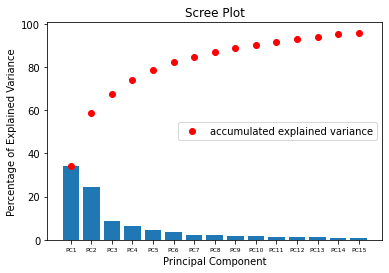

In [16]:
import os
import torch

from data_plotting import DataPlotter
from data_provider import DataProvider
from utils.evaluation_utils import seed_random
import numpy as np



if __name__ == "__main__":
    os.chdir(os.path.join(original_working_directory, "../"))
    seed_random()
    #rtrain, rtest = DataProvider.get_reduced_dimensions_with_pca(dim=15)
    #print(rtrain.shape)
    DataPlotter.print_pca_scree_plot(30)

    d = DataProvider.get_highest_weight_loading_scores_for_pc(pcn="PC1").head(5)** 2
    print(d)
    #remove .head() in d & print(d.sum()) # should be one -> all features together contribute with a factor to the pca